In [1]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm

import time
from IPython import display

import matplotlib.pyplot as plt

import networkx as nx

from sklearn.mixture import GaussianMixture, GMM

In [2]:
def arr_to_sp(arr):
    sp = []
    for x in arr.reshape((32, 4)):
        sp.append(num_to_letter[np.where(x)[0][0]])
    return ''.join(sp)

In [3]:
def get_most_often(X, clusters_all, cluster):
    mask = clusters_all == cluster
    
    X_u, counts = np.unique(X[mask], return_counts=True, axis = 0)
    
    return X_u[np.argmax(counts)]

In [4]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n))
    #colors_res = np.zeros((n, 4))
    #for i in range(n):
    #    colors_res[i] = colors(i)
    return colors

In [5]:
def clusters_to_colors(clusters, colors):
    cluster_colors = np.zeros((clusters.shape[0], 4))

    for i in range(clusters.shape[0]):
        cluster_colors[i] = colors[clusters[i]]
    
    return cluster_colors

In [6]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [7]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

class GaussianSampleLayer(lasagne.layers.MergeLayer):
    def __init__(self, mu, logsigma, **kwargs):
        self.rng = RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        super(GaussianSampleLayer, self).__init__([mu, logsigma], **kwargs)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.rng.normal(shape)

In [8]:
def KL_divergence(mu, log_sigma):
    KLD = 0.5 * T.sum(1 + 2*log_sigma - T.sqr(mu) - T.exp(2*log_sigma))
    return KLD

def log_likelihood(tgt, mu, ls):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + ls)
            - 0.5 * T.sqr(tgt - mu) / T.exp(2 * ls) )

In [9]:
X = np.load("../data/npy/SlO.npy")
#X_ans_split = np.load("./data/npy/ES3_R1_ans.npy.npz")

In [10]:
#X_ans = np.concatenate(X_ans_split.items()[0][1])

In [11]:
X.shape

(325413, 128)

# VAE 2

internal dim 2
hid 50

In [12]:
input_X = T.matrix("X")
input_shape = [None,32*4]

In [49]:
HU_encoder = 50
HU_decoder = 50
dimZ = 2

In [50]:
vl_input = lasagne.layers.InputLayer(input_shape)

vl_enc_hid_1 = lasagne.layers.DenseLayer(vl_input, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)
vl_enc_hid_2 = lasagne.layers.DenseLayer(vl_enc_hid_1, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)

vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid_2, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid_2, num_units=dimZ, nonlinearity = None)
vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)

vl_dec_hid_1 = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_hid_2 = lasagne.layers.DenseLayer(vl_dec_hid_1, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)

vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid_2, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid_2, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

In [93]:
#lasagne.layers.DenseLayer()
vl_dec_hid_1.params

OrderedDict([(W, {'regularizable', 'trainable'}), (b, {'trainable'})])

In [ ]:
temp_dense = lasagne.layers.DenseLayer(, )

In [51]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
v_loss = -1*(KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=0.001)

# compile training and testing functions
v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X], v_loss)

In [52]:
epochs = 20
v_losses_train = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

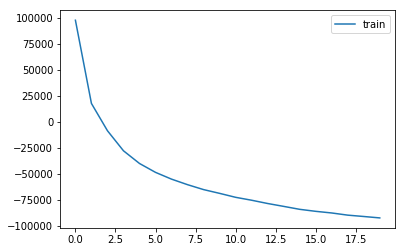

In [54]:
for epoch in range(20):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += v_train_fn(batch)
        #logloss_tr += v_logloss_fn(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    print(ls_tr/ batch_size)
    #v_logloss.append(logloss_tr / batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%1==0:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [55]:
ls_tr


-9226910.4720862359

In [56]:
internal = theano.function([input_X], mu_z)

Z = internal(X)
#Z_ans = internal(X_ans)

In [73]:
u, index, c = np.unique(Z,return_counts=True,axis = 0, return_index=True)

In [79]:
Z_shure = Z[index[np.where(c > 100)]]

# investigate

# Fun 

In [86]:
a = np.zeros(128)
a[::4] = 1 
a
Z_a = internal(a.reshape(1,-1))

In [87]:
Z_a

array([[-0.33539708,  0.39595685]])

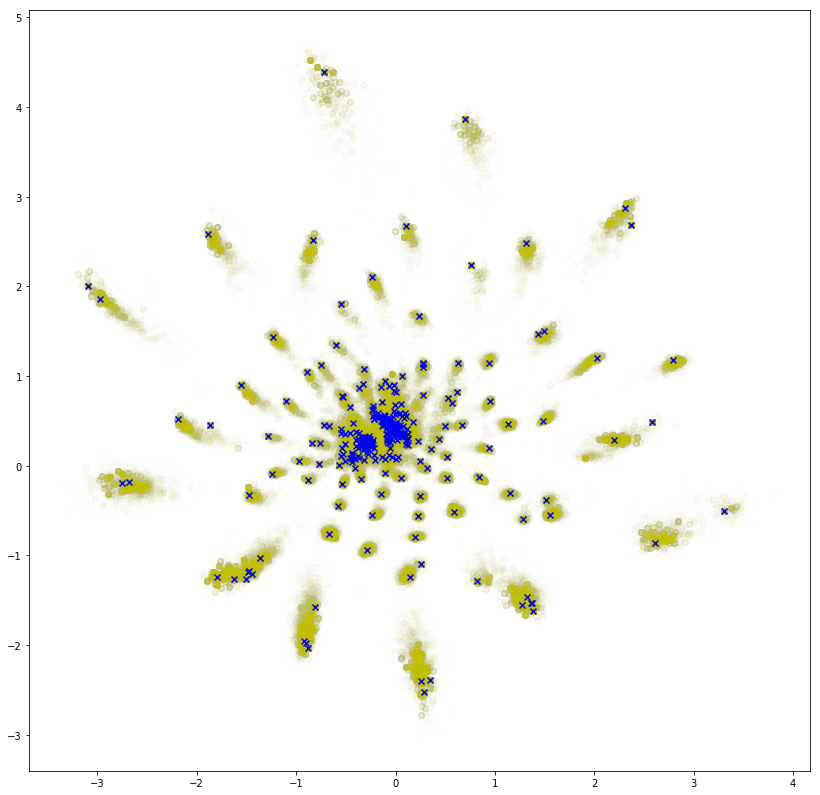

In [92]:

fig, ax =  plt.subplots()
fig.set_size_inches(14, 14)
ax.scatter(Z[:, 0], Z[:,1], c='y',alpha=0.01)
ax.scatter(Z_shure[:, 0], Z_shure[:,1], c='b', marker = 'x')
#ax.scatter(Z_ans[:18, 0]  , Z_ans[:18,1], c='r', marker= 'x', s = 300)
#ax.scatter(Z_ans[18:, 0]  , Z_ans[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

In [40]:
clusters_num = 20

In [41]:
Z_u = np.unique(Z, axis = 0)
gmm = GaussianMixture(clusters_num, verbose = 0, n_init=10)
gmm.fit(Z_u)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [42]:
clusters_all = gmm.predict(Z)
colors = get_cmap(clusters_num)
colors_all = clusters_to_colors(clusters_all, colors)

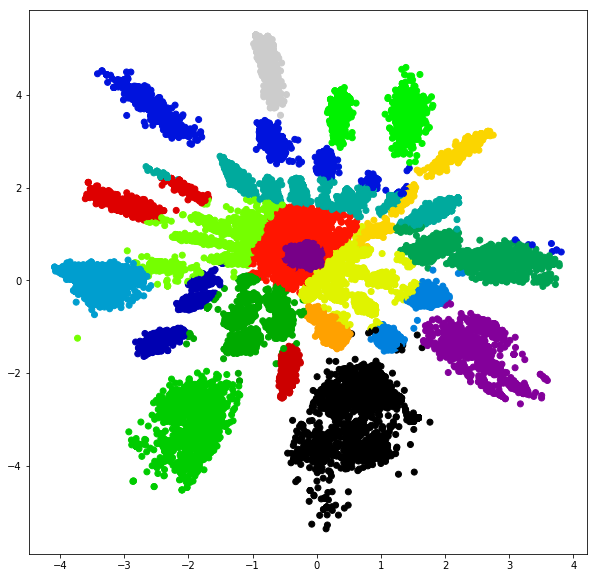

In [43]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z[:, 0], Z[:,1], c=colors_all)
#ax.scatter(Z_ans[:18, 0]  , Z_ans[:18,1], c='r', marker= 'x', s = 300)
#ax.scatter(Z_ans[18:, 0]  , Z_ans[18:,1], c='b' , marker= 'x', s = 300)
plt.show()

In [ ]:


fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z[:, 0], Z[:,1], alpha = 1, c = colors_all)
plt.show()